In [1]:
import os
import numpy as np

from hmog import HmogHelper
from tqdm import tqdm

dataset_path = 'hmog_public_dataset/'

In [10]:
import pickle

test_file = open('preprocessed_data/hmog_dataset_ww_ws', 'rb')
session_hmog_matrices = pickle.load(test_file)
test_file.close()

In [3]:
# We need to exclude subjects who used landscape orientation
landscape_subjects = ['856302', '751131', '220962', '186676', '980953', '201848', '675397']
for l_s in landscape_subjects:
    del session_hmog_matrices[l_s]

subjects_list = list(session_hmog_matrices.keys())
print(f'len: {len(subjects_list)}\n\n{subjects_list}')

len: 92

['342329', '240168', '472761', '352716', '219303', '431312', '556357', '717868', '862649', '990622', '937904', '745224', '841866', '799296', '621276', '827212', '876011', '986737', '171538', '973891', '865881', '248252', '218719', '389015', '918136', '803262', '261313', '207969', '892687', '257279', '785873', '879155', '966655', '326223', '264325', '256487', '553321', '923862', '526319', '733568', '579284', '277905', '777078', '776328', '893255', '100669', '278135', '501973', '405035', '395129', '710707', '578526', '998757', '897652', '737973', '984799', '525584', '913228', '720193', '336172', '785899', '527796', '594887', '588087', '698266', '622852', '815316', '180679', '151985', '962159', '872895', '396697', '538363', '863985', '657486', '856401', '561993', '540641', '893198', '808022', '366286', '663153', '763813', '368258', '539502', '693572', '489146', '771782', '796581', '398248', '865501', '554303']


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

dataset_path = 'preprocessed_data'
session_key_to_int = {'s': 0, 'w': 1}
hmog_features = list(map(str, range(1, 65)))

df = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_ids_types_indices.csv'), index_col=0)
df_20s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_20s.csv'), index_col=0)
df_40s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_40s.csv'), index_col=0)
df_60s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_60s.csv'), index_col=0)
df_80s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_80s.csv'), index_col=0)
df_100s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_100s.csv'), index_col=0)
df_120s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_120s.csv'), index_col=0)
df_140s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_140s.csv'), index_col=0)

scaler = StandardScaler()

df[hmog_features] = scaler.fit_transform(df[hmog_features])
df_20s[hmog_features] = scaler.transform(df_20s[hmog_features])
df_40s[hmog_features] = scaler.transform(df_40s[hmog_features])
df_60s[hmog_features] = scaler.transform(df_60s[hmog_features])
df_80s[hmog_features] = scaler.transform(df_80s[hmog_features])
df_100s[hmog_features] = scaler.transform(df_100s[hmog_features])
df_120s[hmog_features] = scaler.transform(df_120s[hmog_features])
df_140s[hmog_features] = scaler.transform(df_140s[hmog_features])

window_size_to_df = {20000: df_20s,
                     40000: df_40s,
                     60000: df_60s,
                     80000: df_80s,
                     100000: df_100s,
                     120000: df_120s,
                     140000: df_140s}

subjects_list = df['user_id'].unique().tolist()

# Windowed Tests

## Different subjects tests

In [4]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
from hmog.models import models

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

def test_eer(session_hmog_matrices, train_key: str, test_key: str, model_key: str, pos_val: int, neg_val: int):
    window_eers = {}

    for window_size in WINDOW_SIZES:
        eer_list = []

        for i in range(len(subjects_list)):
            subject = subjects_list[i]

            train_hmog_vector = np.vstack((session_hmog_matrices[subject][train_key][0], session_hmog_matrices[subject][train_key][1]))

            std_deviations, train_hmog_vector = HmogHelper.calc_std_and_scale(train_hmog_vector)
            train_hmog_vector_no_timestamp = np.delete(train_hmog_vector, 0, axis=1)

            # We use sessions belonging to the same subject for tests as well (but the sessions are different)
            test_hmog_vector_positive = np.vstack((session_hmog_matrices[subject][test_key][2], session_hmog_matrices[subject][test_key][3]))
            test_hmog_vector_positive = HmogHelper.scale_by(test_hmog_vector_positive, std_deviations)

            test_hmog_vector_negative = None
            
            if model_key == 'svm':
                model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_hmog_vector_no_timestamp)
            elif model_key == 'se':
                model = models.SEClassifier()
                model.fit(train_hmog_vector_no_timestamp)
            elif model_key == 'sm':
                model = models.SMClassifier()
                model.fit(train_hmog_vector_no_timestamp)

            other_subjects = subjects_list.copy()
            del other_subjects[i]

            for another_subject in other_subjects:
                test_hmog_vector_new = np.vstack((session_hmog_matrices[another_subject][test_key][2], session_hmog_matrices[another_subject][test_key][3]))

                if test_hmog_vector_new.shape[0] == 0:
                    continue

                if test_hmog_vector_negative is None:
                    test_hmog_vector_negative = test_hmog_vector_new
                else:
                    test_hmog_vector_negative = np.vstack((test_hmog_vector_negative, test_hmog_vector_new))

            # Now we need to scale the whole vector
            test_hmog_vector_negative = HmogHelper.scale_by(test_hmog_vector_negative, std_deviations)

            predictions_self = HmogHelper.test_hmog_windowed_split(test_hmog_vector_positive, t_window_ms=window_size, model=model)
            y_true = [pos_val] * len(predictions_self)

            predictions_others = HmogHelper.test_hmog_windowed_split(test_hmog_vector_negative, t_window_ms=window_size, model=model)
            y_true += ([neg_val] * len(predictions_others))
            
            scores = predictions_self + predictions_others
            
            # we need to normalize the vectors in case the models are SE or SM
            if model_key == 'se' or model_key == 'sm':
                scores /= max(scores)

            fpr, tpr, thresholds = roc_curve(y_true, scores)

            # Find the threshold where FPR equals FNR
            eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
            eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
            
            # Append EER to the list
            eer_list.append(eer)
        
        population_eer = np.mean(eer_list)
        window_eers[window_size] = population_eer
        print(f'Window size: {window_size / 1000}s\nPopulation EER: {window_eers[window_size]}')

    print('Done')
    return window_eers

In [3]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
from hmog.models import models

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

def get_other_users_test_df_rows(subject: int, session_type: str, window_size: int):
    curr_df = window_size_to_df[window_size]
    
    return curr_df[( ~(curr_df['user_id'] == subject) & (curr_df['session_type'] == session_key_to_int[session_type]) & (( curr_df['session_index'] == 2) | (curr_df['session_index'] == 3) ) )]

def get_user_test_df_rows(subject: int, session_type: str, window_size: int):
    curr_df = window_size_to_df[window_size]
    
    return curr_df[( (curr_df['user_id'] == subject) & (curr_df['session_type'] == session_key_to_int[session_type]) & (( curr_df['session_index'] == 2) | (curr_df['session_index'] == 3) ) )]

def get_all_users_test_vectors(subject: int, session_type: str,  window_size: int):
    df_rows = get_other_users_test_df_rows(subject, session_type, window_size)
    
    return df_rows[hmog_features].to_numpy()

def get_user_test_vector(subject: int, session_type: str, window_size: int):
    df_rows = get_user_test_df_rows(subject, session_type, window_size)
    
    return df_rows[hmog_features].to_numpy()

def test_eer_correct_sliding_window(train_key: str, test_key: str, model_key: str, pos_val: int, neg_val: int):
    window_eers = {}

    for window_size in WINDOW_SIZES:
        eer_list = []

        for i in tqdm(range(len(subjects_list))):
            subject = subjects_list[i]
            
            train_hmog_vector_positive = df[( (df['user_id'] == subject) & (df['session_type'] == session_key_to_int[train_key]) & ( (df['session_index'] == 0) | (df['session_index'] == 1) ) )]
            train_hmog_vector_positive_np = train_hmog_vector_positive[hmog_features].to_numpy()
            
            test_hmog_vector_positive_np = get_user_test_vector(subject, test_key, window_size)
            
            test_hmog_vectors_all_users_np = get_all_users_test_vectors(subject, test_key, window_size)
            
            model = None
            if model_key == 'svm':
                model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_hmog_vector_positive_np)
            elif model_key == 'se':
                model = models.SEClassifier()
                model.fit(train_hmog_vector_positive_np)
            elif model_key == 'sm':
                model = models.SMClassifier()
                model.fit(train_hmog_vector_positive_np)
            
            predictions_self = model.decision_function(test_hmog_vector_positive_np)
            predictions_others = model.decision_function(test_hmog_vectors_all_users_np)
            
            scores = np.concatenate((predictions_self, predictions_others))
            
            y_true = [pos_val] * len(predictions_self)
            y_true += ([neg_val] * len(predictions_others))
            
            fpr, tpr, thresholds = roc_curve(y_true, scores)

            # Find the threshold where FPR equals FNR
            eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
            eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2

            # Append EER to the list
            eer_list.append(eer)
                
        population_eer = np.mean(eer_list)
        window_eers[window_size] = population_eer
        print(f'Window size: {window_size / 1000}s\nPopulation EER: {window_eers[window_size]}')

    print('Done')
    return window_eers

In [45]:
# svm_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'svm', 1, -1)
# svm_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'svm', 1, -1)
# svm_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'svm', 1, -1)
# svm_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'svm', 1, -1)

svm_ww_ww_eers = test_eer_correct_sliding_window('w', 'w', 'svm', 1, -1)
svm_ws_ws_eers = test_eer_correct_sliding_window('s', 's', 'svm', 1, -1)
svm_ww_ws_eers = test_eer_correct_sliding_window('w', 's', 'svm', 1, -1)
svm_ws_ww_eers = test_eer_correct_sliding_window('s', 'w', 'svm', 1, -1)


100%|██████████| 92/92 [02:19<00:00,  1.52s/it]


Window size: 20.0s
Population EER: 0.2131695816974143


100%|██████████| 92/92 [02:20<00:00,  1.53s/it]


Window size: 40.0s
Population EER: 0.20819880527065446


  2%|▏         | 2/92 [00:05<04:19,  2.88s/it]


KeyboardInterrupt: 

In [4]:
# se_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'se', 0, 1)
# se_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'se', 0, 1)
# se_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'se', 0, 1)
# se_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'se', 0, 1)

se_ww_ww_eers = test_eer_correct_sliding_window('w', 'w', 'se', 0, 1)
se_ws_ws_eers = test_eer_correct_sliding_window('s', 's', 'se', 0, 1)
se_ww_ws_eers = test_eer_correct_sliding_window('w', 's', 'se', 0, 1)
se_ws_ww_eers = test_eer_correct_sliding_window('s', 'w', 'se', 0, 1)

100%|██████████| 92/92 [00:08<00:00, 10.85it/s]


Window size: 20.0s
Population EER: 0.15654144440983497


100%|██████████| 92/92 [00:08<00:00, 11.03it/s]


Window size: 40.0s
Population EER: 0.13072737936194753


100%|██████████| 92/92 [00:08<00:00, 10.87it/s]


Window size: 60.0s
Population EER: 0.12262510019713177


100%|██████████| 92/92 [00:08<00:00, 11.18it/s]


Window size: 80.0s
Population EER: 0.11876260244006363


100%|██████████| 92/92 [00:07<00:00, 11.76it/s]


Window size: 100.0s
Population EER: 0.11591764149377695


100%|██████████| 92/92 [00:07<00:00, 11.84it/s]


Window size: 120.0s
Population EER: 0.11311029426069094


100%|██████████| 92/92 [00:07<00:00, 11.79it/s]


Window size: 140.0s
Population EER: 0.11205975186509415
Done


100%|██████████| 92/92 [00:07<00:00, 12.15it/s]


Window size: 20.0s
Population EER: 0.1774633904792727


100%|██████████| 92/92 [00:07<00:00, 11.99it/s]


Window size: 40.0s
Population EER: 0.16372288752596975


100%|██████████| 92/92 [00:07<00:00, 12.05it/s]


Window size: 60.0s
Population EER: 0.1581152923076944


100%|██████████| 92/92 [00:07<00:00, 11.95it/s]


Window size: 80.0s
Population EER: 0.15997383696200249


100%|██████████| 92/92 [00:07<00:00, 12.01it/s]


Window size: 100.0s
Population EER: 0.15837804052212925


100%|██████████| 92/92 [00:07<00:00, 11.66it/s]


Window size: 120.0s
Population EER: 0.15723691443035542


100%|██████████| 92/92 [00:07<00:00, 11.67it/s]


Window size: 140.0s
Population EER: 0.15670736416311448
Done


100%|██████████| 92/92 [00:07<00:00, 11.66it/s]


Window size: 20.0s
Population EER: 0.30000162287648885


100%|██████████| 92/92 [00:07<00:00, 11.71it/s]


Window size: 40.0s
Population EER: 0.2921173793553371


100%|██████████| 92/92 [00:07<00:00, 11.73it/s]


Window size: 60.0s
Population EER: 0.2892032046801341


100%|██████████| 92/92 [00:07<00:00, 11.93it/s]


Window size: 80.0s
Population EER: 0.2861957813301693


100%|██████████| 92/92 [00:07<00:00, 11.86it/s]


Window size: 100.0s
Population EER: 0.28458336419292374


100%|██████████| 92/92 [00:07<00:00, 11.95it/s]


Window size: 120.0s
Population EER: 0.2827852108069557


100%|██████████| 92/92 [00:07<00:00, 11.99it/s]


Window size: 140.0s
Population EER: 0.2812388410524461
Done


100%|██████████| 92/92 [00:07<00:00, 11.98it/s]


Window size: 20.0s
Population EER: 0.3581679277959682


100%|██████████| 92/92 [00:07<00:00, 11.67it/s]


Window size: 40.0s
Population EER: 0.34632165094613226


100%|██████████| 92/92 [00:07<00:00, 11.75it/s]


Window size: 60.0s
Population EER: 0.3415864532978863


100%|██████████| 92/92 [00:07<00:00, 11.89it/s]


Window size: 80.0s
Population EER: 0.33892728782795983


100%|██████████| 92/92 [00:07<00:00, 11.90it/s]


Window size: 100.0s
Population EER: 0.33702085584625224


100%|██████████| 92/92 [00:07<00:00, 11.85it/s]


Window size: 120.0s
Population EER: 0.33610685399143114


100%|██████████| 92/92 [00:07<00:00, 11.74it/s]

Window size: 140.0s
Population EER: 0.33537482919346967
Done


In [5]:
# sm_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'sm', 0, 1)
# sm_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'sm', 0, 1)
# sm_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'sm', 0, 1)
# sm_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'sm', 0, 1)

sm_ww_ww_eers = test_eer_correct_sliding_window('w', 'w', 'sm', 0, 1)
sm_ws_ws_eers = test_eer_correct_sliding_window('s', 's', 'sm', 0, 1)
sm_ww_ws_eers = test_eer_correct_sliding_window('w', 's', 'sm', 0, 1)
sm_ws_ww_eers = test_eer_correct_sliding_window('s', 'w', 'sm', 0, 1)

100%|██████████| 92/92 [00:26<00:00,  3.53it/s]


Window size: 20.0s
Population EER: 0.1595163812340358


100%|██████████| 92/92 [00:26<00:00,  3.42it/s]


Window size: 40.0s
Population EER: 0.12796106859652473


100%|██████████| 92/92 [00:26<00:00,  3.44it/s]


Window size: 60.0s
Population EER: 0.11679557430221493


100%|██████████| 92/92 [00:26<00:00,  3.46it/s]


Window size: 80.0s
Population EER: 0.11209477247183357


100%|██████████| 92/92 [00:26<00:00,  3.47it/s]


Window size: 100.0s
Population EER: 0.10816574116996744


100%|██████████| 92/92 [00:26<00:00,  3.47it/s]


Window size: 120.0s
Population EER: 0.10445117294677518


100%|██████████| 92/92 [00:26<00:00,  3.47it/s]


Window size: 140.0s
Population EER: 0.1024756336615415
Done


100%|██████████| 92/92 [00:25<00:00,  3.57it/s]


Window size: 20.0s
Population EER: 0.16078319394644047


100%|██████████| 92/92 [00:26<00:00,  3.52it/s]


Window size: 40.0s
Population EER: 0.1385928446534903


100%|██████████| 92/92 [00:26<00:00,  3.51it/s]


Window size: 60.0s
Population EER: 0.12792116571631626


100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Window size: 80.0s
Population EER: 0.12277893176953095


100%|██████████| 92/92 [00:26<00:00,  3.52it/s]


Window size: 100.0s
Population EER: 0.11960965680054252


100%|██████████| 92/92 [00:26<00:00,  3.52it/s]


Window size: 120.0s
Population EER: 0.11731801117061652


100%|██████████| 92/92 [00:26<00:00,  3.53it/s]


Window size: 140.0s
Population EER: 0.11583020149469495
Done


100%|██████████| 92/92 [00:25<00:00,  3.56it/s]


Window size: 20.0s
Population EER: 0.2903632729842963


100%|██████████| 92/92 [00:25<00:00,  3.55it/s]


Window size: 40.0s
Population EER: 0.2779699304681926


100%|██████████| 92/92 [00:25<00:00,  3.54it/s]


Window size: 60.0s
Population EER: 0.2723733485052797


100%|██████████| 92/92 [00:26<00:00,  3.52it/s]


Window size: 80.0s
Population EER: 0.26773654418265763


100%|██████████| 92/92 [00:25<00:00,  3.55it/s]


Window size: 100.0s
Population EER: 0.2642519260787973


100%|██████████| 92/92 [00:25<00:00,  3.55it/s]


Window size: 120.0s
Population EER: 0.26206851322108254


100%|██████████| 92/92 [00:25<00:00,  3.55it/s]


Window size: 140.0s
Population EER: 0.26064521134897534
Done


100%|██████████| 92/92 [00:25<00:00,  3.54it/s]


Window size: 20.0s
Population EER: 0.3864013467266653


100%|██████████| 92/92 [00:26<00:00,  3.49it/s]


Window size: 40.0s
Population EER: 0.37406774782994573


100%|██████████| 92/92 [00:26<00:00,  3.51it/s]


Window size: 60.0s
Population EER: 0.3675172371119751


100%|██████████| 92/92 [00:26<00:00,  3.49it/s]


Window size: 80.0s
Population EER: 0.3638241588178121


100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Window size: 100.0s
Population EER: 0.3614321761307356


100%|██████████| 92/92 [00:26<00:00,  3.48it/s]


Window size: 120.0s
Population EER: 0.3597640446615532


100%|██████████| 92/92 [00:26<00:00,  3.51it/s]

Window size: 140.0s
Population EER: 0.358024558469362
Done


# Data Pickling

In [4]:
import pickle
import os

def pickle_results(values: list, results_path: str, filename: str):
    abs_path = os.path.join(results_path, filename)
    if not os.path.exists(abs_path):
        result_file = open(abs_path, 'wb')
        pickle.dump(values, result_file)
        result_file.close()

In [7]:
pickle_results(list(svm_ww_ww_eers.values()), 'results/', 'svm_ww_ww_eers')
pickle_results(list(svm_ws_ws_eers.values()), 'results/', 'svm_ws_ws_eers')
pickle_results(list(svm_ww_ws_eers.values()), 'results/', 'svm_ww_ws_eers')
pickle_results(list(svm_ws_ww_eers.values()), 'results/', 'svm_ws_ww_eers')

pickle_results(list(se_ww_ww_eers.values()), 'results/', 'se_ww_ww_eers')
pickle_results(list(se_ws_ws_eers.values()), 'results/', 'se_ws_ws_eers')
pickle_results(list(se_ww_ws_eers.values()), 'results/', 'se_ww_ws_eers')
pickle_results(list(se_ws_ww_eers.values()), 'results/', 'se_ws_ww_eers')

pickle_results(list(sm_ww_ww_eers.values()), 'results/', 'sm_ww_ww_eers')
pickle_results(list(sm_ws_ws_eers.values()), 'results/', 'sm_ws_ws_eers')
pickle_results(list(sm_ww_ws_eers.values()), 'results/', 'sm_ww_ws_eers')
pickle_results(list(sm_ws_ww_eers.values()), 'results/', 'sm_ws_ww_eers')

# Visualisations

## Tables
Let's put all results into a table (window_size vs. sm/se/oneclasssvm)

In [5]:
# But firstly, let's load saved data since testing takes noticeable amount of time
import pickle
import os

def load_result(path_to_file: str):
    if os.path.exists(path_to_file):
        result_file = open(path_to_file, 'rb')
        result = pickle.load(result_file)
        result_file.close()

        return result
    return []

In [17]:
svm_ww_ww_eers = load_result('results/svm_ww_ww_eers')
svm_ws_ws_eers = load_result('results/svm_ws_ws_eers')
svm_ww_ws_eers = load_result('results/svm_ww_ws_eers')
svm_ws_ww_eers = load_result('results/svm_ws_ww_eers')

se_ww_ww_eers = load_result('results/se_ww_ww_eers')
se_ws_ws_eers = load_result('results/se_ws_ws_eers')
se_ww_ws_eers = load_result('results/se_ww_ws_eers')
se_ws_ww_eers = load_result('results/se_ws_ww_eers')

sm_ww_ww_eers = load_result('results/sm_ww_ww_eers')
sm_ws_ws_eers = load_result('results/sm_ws_ws_eers')
sm_ww_ws_eers = load_result('results/sm_ww_ws_eers')
sm_ws_ww_eers = load_result('results/sm_ws_ww_eers')

In [10]:
from tabulate import tabulate

windows_seconds = [size / 1000 for size in WINDOW_SIZES]
header = ['Model'] + [f'{window_s}s.' for window_s in windows_seconds]

table_ww_ww = [header,
              ['OneClassSVM'] + svm_ww_ww_eers,
              ['SE'] + se_ww_ww_eers,
              ['SM'] + sm_ww_ww_eers]

table_ws_ws = [header,
              ['OneClassSVM'] + svm_ws_ws_eers,
              ['SE'] + se_ws_ws_eers,
              ['SM'] + sm_ws_ws_eers]

table_ww_ws = [header,
              ['OneClassSVM'] + svm_ww_ws_eers,
              ['SE'] + se_ww_ws_eers,
              ['SM'] + sm_ww_ws_eers]

table_ws_ww = [header,
              ['OneClassSVM'] + svm_ws_ww_eers,
              ['SE'] + se_ws_ww_eers,
              ['SM'] + sm_ws_ww_eers]

print('walking + walking tests\n', tabulate(table_ww_ww, headers='firstrow'), end='\n\n')
print('sitting + sitting tests\n', tabulate(table_ws_ws, headers='firstrow'), end='\n\n')
print('walking + sitting tests\n', tabulate(table_ww_ws, headers='firstrow'), end='\n\n')
print('sitting + walking tests\n', tabulate(table_ws_ww, headers='firstrow'), end='\n\n')

walking + walking tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.    140.0s.
-----------  --------  --------  --------  --------  ---------  ---------  ---------
OneClassSVM  0.21317   0.208199  0.206227  0.203242   0.200744   0.199589   0.199948
SE           0.156541  0.130727  0.122625  0.118763   0.115918   0.11311    0.11206
SM           0.159516  0.127961  0.116796  0.112095   0.108166   0.104451   0.102476

sitting + sitting tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.    140.0s.
-----------  --------  --------  --------  --------  ---------  ---------  ---------
OneClassSVM  0.258105  0.250991  0.253746  0.251734   0.250152   0.248671   0.247083
SE           0.177463  0.163723  0.158115  0.159974   0.158378   0.157237   0.156707
SM           0.160783  0.138593  0.127921  0.122779   0.11961    0.117318   0.11583

walking + sitting tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.  

## Plots

In [18]:
import matplotlib.pyplot as plt

def plot(data: list, xlabel: str, ylabel: str, title: str):
    y_lim_lower = 0
    y_lim_upper = 0.6

    for values, curve_label in data:
        plt.plot(windows_seconds, list(values), linestyle='dotted', label=curve_label)

    plt.ylim(y_lim_lower, y_lim_upper)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

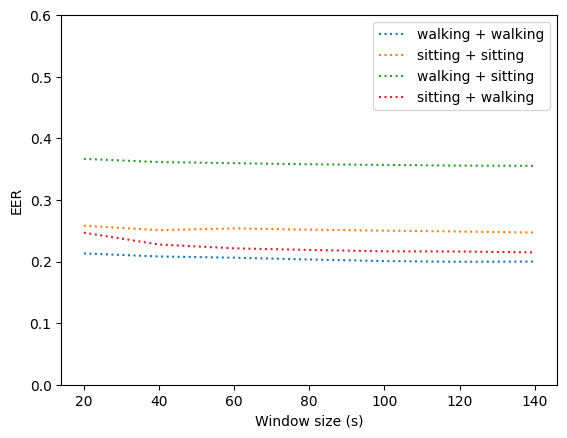

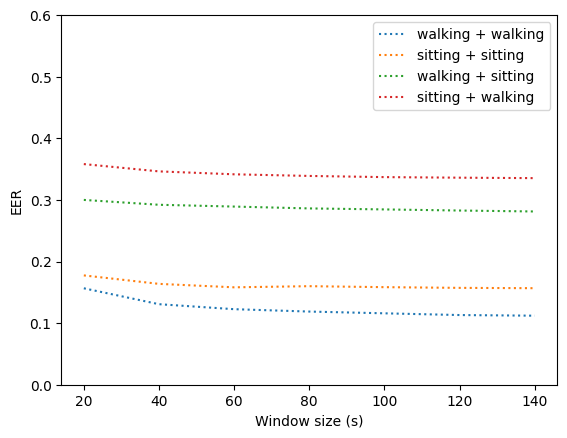

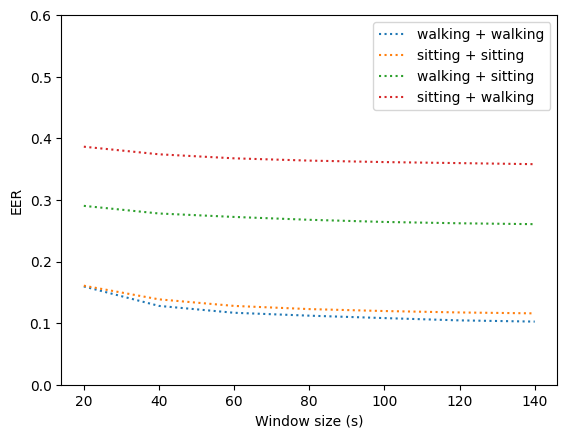

In [12]:
svm_all_data_comparison = [(svm_ww_ww_eers, 'walking + walking'),
                           (svm_ws_ws_eers, 'sitting + sitting'),
                           (svm_ww_ws_eers, 'walking + sitting'),
                           (svm_ws_ww_eers, 'sitting + walking')]

se_all_data_comparison = [(se_ww_ww_eers, 'walking + walking'),
                          (se_ws_ws_eers, 'sitting + sitting'),
                          (se_ww_ws_eers, 'walking + sitting'),
                          (se_ws_ww_eers, 'sitting + walking')]

sm_all_data_comparison = [(sm_ww_ww_eers, 'walking + walking'),
                          (sm_ws_ws_eers, 'sitting + sitting'),
                          (sm_ww_ws_eers, 'walking + sitting'),
                          (sm_ws_ww_eers, 'sitting + walking')]

# plot(svm_all_data_comparison, 'Window size (s)', 'EER', 'OneClassSVM')
# plot(se_all_data_comparison, 'Window size (s)', 'EER', 'Scaled Euclidean')
# plot(sm_all_data_comparison, 'Window size (s)', 'EER', 'Scaled Manhattan')

plot(svm_all_data_comparison, 'Window size (s)', 'EER', '')
plot(se_all_data_comparison, 'Window size (s)', 'EER', '')
plot(sm_all_data_comparison, 'Window size (s)', 'EER', '')

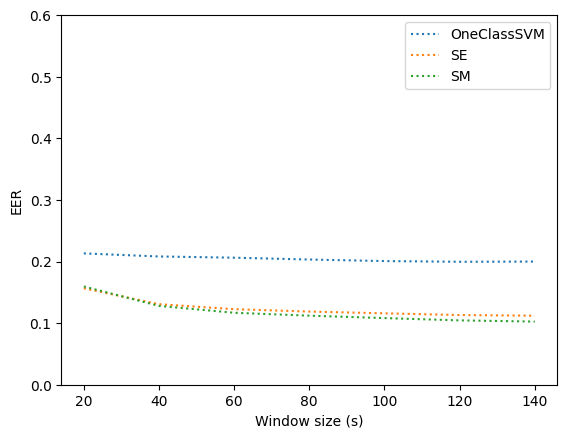

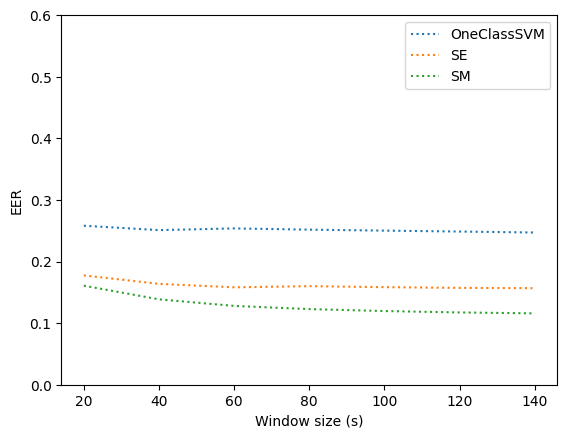

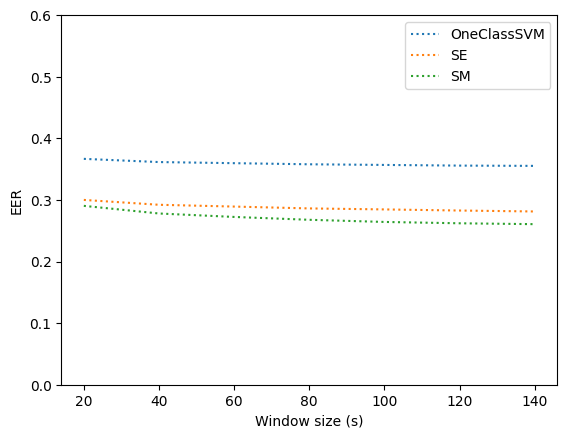

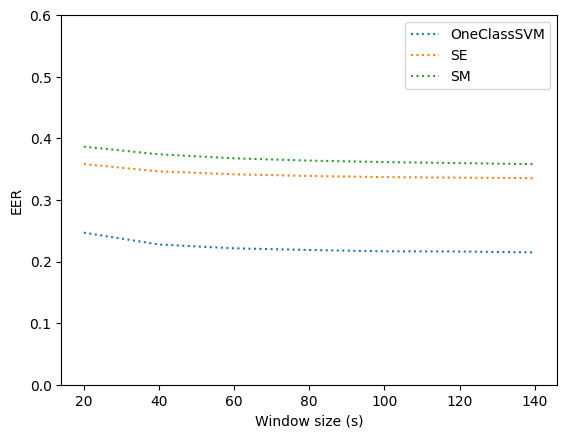

In [13]:
ww_ww_data_comparison = [(svm_ww_ww_eers, 'OneClassSVM'),
                      (se_ww_ww_eers, 'SE'),
                      (sm_ww_ww_eers, 'SM')]

ws_ws_data_comparison = [(svm_ws_ws_eers, 'OneClassSVM'),
                         (se_ws_ws_eers, 'SE'),
                         (sm_ws_ws_eers, 'SM')]

ww_ws_data_comparison = [(svm_ww_ws_eers, 'OneClassSVM'),
                         (se_ww_ws_eers, 'SE'),
                         (sm_ww_ws_eers, 'SM')]

ws_ww_data_comparison = [(svm_ws_ww_eers, 'OneClassSVM'),
                         (se_ws_ww_eers, 'SE'),
                         (sm_ws_ww_eers, 'SM')]

# plot(ww_ww_data_comparison, 'Window size (s)', 'EER', 'walking + walking comparison')
# plot(ws_ws_data_comparison, 'Window size (s)', 'EER', 'sitting + sitting comparison')
# plot(ww_ws_data_comparison, 'Window size (s)', 'EER', 'walking + sitting comparison')
# plot(ws_ww_data_comparison, 'Window size (s)', 'EER', 'sitting + walking comparison')

plot(ww_ww_data_comparison, 'Window size (s)', 'EER', '')
plot(ws_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(ww_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(ws_ww_data_comparison, 'Window size (s)', 'EER', '')

## Tests with activity classification model

Let's for each subject:
1. Train two models: the first one on sitting sessions and the second one on walking sessions
2. Use a model that classifies current activity (walking or sitting)
3. Based on output of that model, pick an authentication model

Let's do that for separate tests on walking and sitting

In [7]:
import torch.nn as nn

class SimpleNeuralNet(nn.Module):
    def __init__(self) -> None:
        super(SimpleNeuralNet, self).__init__()

        input_shape = 64

        self.fc1 = nn.Linear(input_shape, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=16, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.out(x)

        return x

In [8]:
def load_activity_model():
    return torch.load('classification_model_auc_097')

In [9]:
import torch

from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
from hmog.models import models

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]
ACTIVITY_THRESHOLD = 0.5

model_activity = load_activity_model()
model_activity.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test_eer_with_activity(test_key: str, model_key: str, pos_val: int, neg_val: int):
    window_eers = {window_size: [] for window_size in WINDOW_SIZES}
    
    for i in tqdm(range(len(subjects_list))):
        subject = subjects_list[i]
        
        # We train two models: on walking and sitting sessions
        train_walk_hmog_vector = df[( (df['user_id'] == subject) & (df['session_type'] == session_key_to_int['w']) & ( (df['session_index'] == 0) | (df['session_index'] == 1) ) )]
        train_sit_hmog_vector = df[( (df['user_id'] == subject) & (df['session_type'] == session_key_to_int['s']) & ( (df['session_index'] == 0) | (df['session_index'] == 1) ) )]
        
        train_walk_hmog_vector_np = train_walk_hmog_vector[hmog_features].to_numpy()
        train_sit_hmog_vector_np = train_sit_hmog_vector[hmog_features].to_numpy()
        
        model_walk = None
        model_sit = None
        
        if model_key == 'svm':
            model_walk = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_walk_hmog_vector_np)
            model_sit  = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_sit_hmog_vector_np)
        elif model_key == 'se':
            model_walk = models.SEClassifier()
            model_sit = models.SEClassifier()
            
            model_walk.fit(train_walk_hmog_vector_np)
            model_sit.fit(train_sit_hmog_vector_np)
        elif model_key == 'sm':
            model_walk = models.SMClassifier()
            model_sit = models.SMClassifier()
            
            model_walk.fit(train_walk_hmog_vector_np)
            model_sit.fit(train_sit_hmog_vector_np)
        
        for window_size in WINDOW_SIZES:
            # We use sessions belonging to the same subject for tests as well (but the sessions are different)
            test_hmog_vector_positive = get_user_test_df_rows(subject, test_key, window_size)
            test_hmog_vector_negative = get_other_users_test_df_rows(subject, test_key, window_size)
            test_hmog_vector_df = pd.concat([test_hmog_vector_positive, test_hmog_vector_negative], ignore_index=True)
    
            hmog_vectors_combined = test_hmog_vector_df[hmog_features].to_numpy()
            hmog_vectors_combined_tensor = torch.tensor(hmog_vectors_combined).to(device, dtype=torch.float32)
    
            # Now let's predict if current test vector contains walking or sitting data
            activity_predictions = model_activity.forward(hmog_vectors_combined_tensor).reshape(-1).cpu().detach().numpy()
            walking_indices = pd.Series(np.where(activity_predictions >= ACTIVITY_THRESHOLD, True, False))
            sitting_indices = pd.Series(np.where(activity_predictions < ACTIVITY_THRESHOLD, True, False))
            
            walking_hmog_rows = test_hmog_vector_df[walking_indices]
            sitting_hmog_rows = test_hmog_vector_df[sitting_indices]
            
            predictions_walking = []
            predictions_sitting = []
            if not walking_hmog_rows.empty:
                predictions_walking = model_walk.decision_function(walking_hmog_rows[hmog_features].to_numpy())
            if not sitting_hmog_rows.empty:
                predictions_sitting = model_sit.decision_function(sitting_hmog_rows[hmog_features].to_numpy())
    
            predictions = np.concatenate((predictions_walking, predictions_sitting))
            y_true = pd.concat((walking_hmog_rows, sitting_hmog_rows))['user_id']
            y_true.loc[y_true != subject] = neg_val
            y_true.loc[y_true == subject] = pos_val
    
            fpr, tpr, thresholds = roc_curve(y_true.to_numpy(), predictions)
    
            # Find the threshold where FPR equals FNR
            eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
            eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
            
            # Append EER to the list
            window_eers[window_size].append(eer)
    
    for window_size in WINDOW_SIZES:
        window_eers[window_size] = np.mean(window_eers[window_size])
        print(f'Window size: {window_size / 1000}s\nPopulation EER: {window_eers[window_size]}')
    
    print('Done')
    return window_eers

In [10]:
svm_act_ww_eers = test_eer_with_activity('w', 'svm', 1, -1)
svm_act_ws_eers = test_eer_with_activity('s', 'svm', 1, -1)

100%|██████████| 92/92 [09:39<00:00,  6.30s/it]


Window size: 20.0s
Population EER: 0.31746471907835344
Window size: 40.0s
Population EER: 0.290996165665706
Window size: 60.0s
Population EER: 0.2750719285268094
Window size: 80.0s
Population EER: 0.2620820943518398
Window size: 100.0s
Population EER: 0.25728826459167725
Window size: 120.0s
Population EER: 0.25286295219701194
Window size: 140.0s
Population EER: 0.25183639262953295
Done


100%|██████████| 92/92 [06:47<00:00,  4.43s/it]

Window size: 20.0s
Population EER: 0.2581699089357727
Window size: 40.0s
Population EER: 0.25102257607742795
Window size: 60.0s
Population EER: 0.2537461857258905
Window size: 80.0s
Population EER: 0.2517335677201896
Window size: 100.0s
Population EER: 0.25015233921277835
Window size: 120.0s
Population EER: 0.24867135374185778
Window size: 140.0s
Population EER: 0.2470833897434209
Done


In [12]:
se_act_ww_eers = test_eer_with_activity('w', 'se', 0, 1)
se_act_ws_eers = test_eer_with_activity('s', 'se', 0, 1)

100%|██████████| 92/92 [01:37<00:00,  1.06s/it]


Window size: 20.0s
Population EER: 0.30222515830347746
Window size: 40.0s
Population EER: 0.3136570491960909
Window size: 60.0s
Population EER: 0.3143505576584042
Window size: 80.0s
Population EER: 0.3149032313075958
Window size: 100.0s
Population EER: 0.3164902835961269
Window size: 120.0s
Population EER: 0.3163533061448667
Window size: 140.0s
Population EER: 0.31586265612119446
Done


100%|██████████| 92/92 [01:25<00:00,  1.07it/s]

Window size: 20.0s
Population EER: 0.1774972975424155
Window size: 40.0s
Population EER: 0.1637662036036498
Window size: 60.0s
Population EER: 0.1581152923076944
Window size: 80.0s
Population EER: 0.15997383696200249
Window size: 100.0s
Population EER: 0.15837804052212925
Window size: 120.0s
Population EER: 0.15723691443035542
Window size: 140.0s
Population EER: 0.15670736416311448
Done


In [13]:
sm_act_ww_eers = test_eer_with_activity('w', 'sm', 0, 1)
sm_act_ws_eers = test_eer_with_activity('s', 'sm', 0, 1)

100%|██████████| 92/92 [03:46<00:00,  2.46s/it]


Window size: 20.0s
Population EER: 0.32074861252458786
Window size: 40.0s
Population EER: 0.33162243846389017
Window size: 60.0s
Population EER: 0.33543497669023425
Window size: 80.0s
Population EER: 0.3366537199021348
Window size: 100.0s
Population EER: 0.3361766763408024
Window size: 120.0s
Population EER: 0.33524563856017453
Window size: 140.0s
Population EER: 0.3336253032173657
Done


100%|██████████| 92/92 [03:35<00:00,  2.35s/it]

Window size: 20.0s
Population EER: 0.16082928777709973
Window size: 40.0s
Population EER: 0.13862319925356129
Window size: 60.0s
Population EER: 0.12792116571631626
Window size: 80.0s
Population EER: 0.12277893176953095
Window size: 100.0s
Population EER: 0.11960965680054252
Window size: 120.0s
Population EER: 0.11731801117061652
Window size: 140.0s
Population EER: 0.11583020149469495
Done


In [14]:
pickle_results(list(svm_act_ww_eers.values()), 'results/with_activity_recog/', 'svm_act_ww_eers')
pickle_results(list(svm_act_ws_eers.values()), 'results/with_activity_recog/', 'svm_act_ws_eers')

pickle_results(list(se_act_ww_eers.values()), 'results/with_activity_recog/', 'se_act_ww_eers')
pickle_results(list(se_act_ws_eers.values()), 'results/with_activity_recog/', 'se_act_ws_eers')

pickle_results(list(sm_act_ww_eers.values()), 'results/with_activity_recog/', 'sm_act_ww_eers')
pickle_results(list(sm_act_ws_eers.values()), 'results/with_activity_recog/', 'sm_act_ws_eers')

## Visualisations of Results with Activity Recognition

In [15]:
svm_act_ww_eers = load_result('results/with_activity_recog/svm_act_ww_eers')
svm_act_ws_eers = load_result('results/with_activity_recog/svm_act_ws_eers')

se_act_ww_eers = load_result('results/with_activity_recog/se_act_ww_eers')
se_act_ws_eers = load_result('results/with_activity_recog/se_act_ws_eers')

sm_act_ww_eers = load_result('results/with_activity_recog/sm_act_ww_eers')
sm_act_ws_eers = load_result('results/with_activity_recog/sm_act_ws_eers')

In [19]:
WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]
windows_seconds = [size / 1000 for size in WINDOW_SIZES]

svm_ww_ws_vs_act_ws_data_comparison = [(svm_act_ws_eers, 'multi-level OneClassSVM'),
                                       (svm_ww_ws_eers, 'OneClassSVM')]
svm_ws_ww_vs_act_ww_data_comparison = [(svm_act_ww_eers, 'multi-level OneClassSVM'),
                                       (svm_ws_ww_eers, 'OneClassSVM')]

se_ww_ws_vs_act_ws_data_comparison = [(se_act_ws_eers, 'multi-level SE'),
                                       (se_ww_ws_eers, 'SE')]
se_ws_ww_vs_act_ww_data_comparison = [(se_act_ww_eers, 'multi-level SE'),
                                       (se_ws_ww_eers, 'SE')]

sm_ww_ws_vs_act_ws_data_comparison = [(sm_act_ws_eers, 'multi-level SM'),
                                       (sm_ww_ws_eers, 'SM')]
sm_ws_ww_vs_act_ww_data_comparison = [(sm_act_ww_eers, 'multi-level SM'),
                                       (sm_ws_ww_eers, 'SM')]

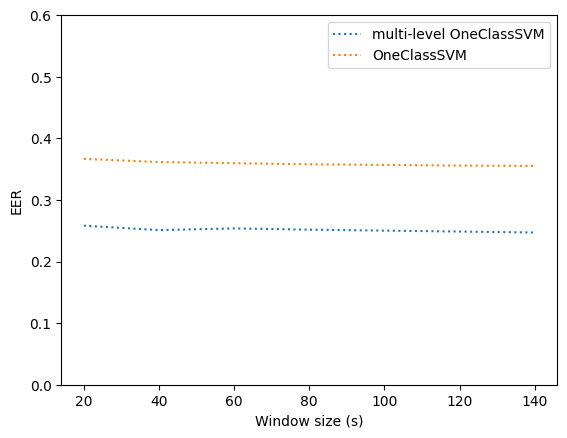

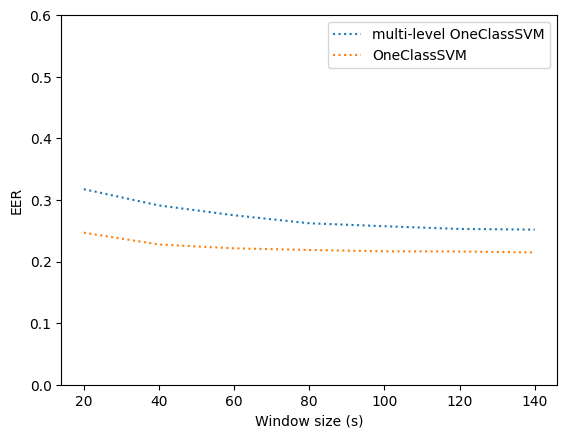

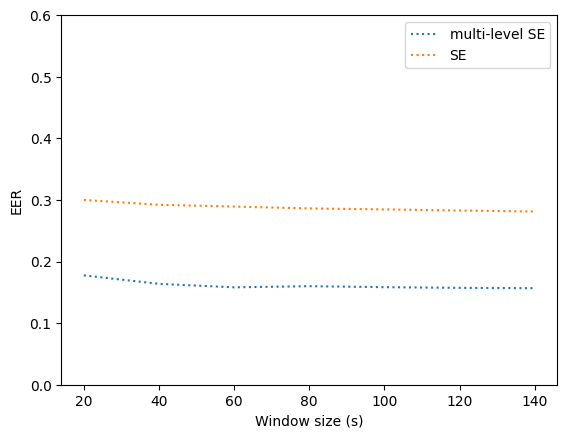

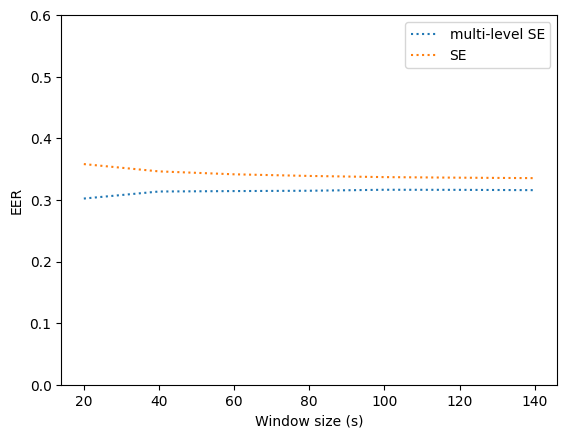

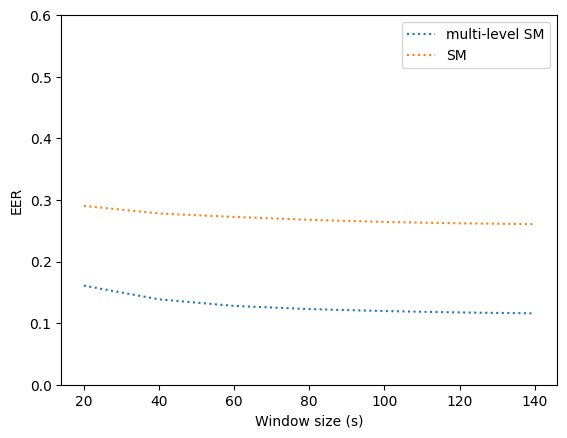

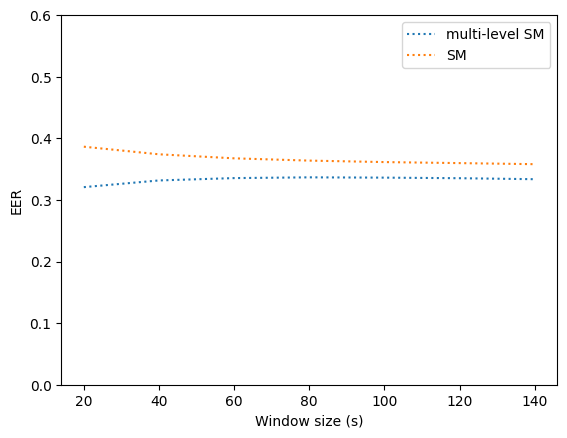

In [20]:
plot(svm_ww_ws_vs_act_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(svm_ws_ww_vs_act_ww_data_comparison, 'Window size (s)', 'EER', '')

plot(se_ww_ws_vs_act_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(se_ws_ww_vs_act_ww_data_comparison, 'Window size (s)', 'EER', '')

plot(sm_ww_ws_vs_act_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(sm_ws_ww_vs_act_ww_data_comparison, 'Window size (s)', 'EER', '')

## Improvement in numbers

In [19]:
import matplotlib.pyplot as plt

avg_svm_ws_eer = np.mean(svm_ww_ws_eers)
avg_se_ws_eer = np.mean(se_ww_ws_eers)
avg_sm_ws_eer = np.mean(sm_ww_ws_eers)

avg_svm_ww_eer = np.mean(svm_ww_ww_eers)
avg_se_ww_eer = np.mean(se_ww_ww_eers)
avg_sm_ww_eer = np.mean(sm_ww_ww_eers)

avg_svm_act_ws_eer = np.mean(svm_act_ws_eers)
avg_se_act_ws_eer = np.mean(se_act_ws_eers)
avg_sm_act_ws_eer = np.mean(sm_act_ws_eers)

avg_svm_act_ww_eer = np.mean(svm_act_ww_eers)
avg_se_act_ww_eer = np.mean(se_act_ww_eers)
avg_sm_act_ww_eer = np.mean(sm_act_ww_eers)

print(avg_svm_ws_eer / avg_svm_act_ws_eer, avg_svm_ws_eer, avg_svm_act_ws_eer)

1.6313468578417691 0.3247721014160834 0.1990821877364258
